In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

pushpakhinglaspure_cats_vs_dogs_path = kagglehub.dataset_download('pushpakhinglaspure/cats-vs-dogs')
danielfodi_unseen_dog_cat_images_path = kagglehub.dataset_download('danielfodi/unseen-dog-cat-images')

print('Data source import complete.')


# Dog vs Cat Image Classification Using SVM

## Project Overview
The objective of this project is to classify images of cats and dogs using a Support Vector Machine (SVM). This is a binary classification problem where the SVM is trained to distinguish between two categories: cats and dogs. The project uses the Kaggle Cats and Dogs dataset, which contains labeled images for training and testing purposes.

### Key Objectives
1. Implement a robust and efficient pipeline for preprocessing image data.
2. Extract meaningful features from images to enable SVM classification.
3. Train an SVM model on the extracted features.
4. Evaluate the model's performance and fine-tune it for optimal results.
5. Deploy the model to classify unseen images accurately.

---

## Project Approach

### 1. Dataset Preparation
- **Data Source**: https://www.kaggle.com/datasets/pushpakhinglaspure/cats-vs-dogs/data .The Kaggle Cats and Dogs dataset, containing thousands of labeled images.
- **Data Splitting**:
  - The dataset already comes with a predefined train-test split:
    - **Training Set**: 10,000 images each for cats and dogs (total: 20,000 images).
    - **Testing Set**: 2,500 images each for cats and dogs (total: 5,000 images).
  - This satisfies the 80% training and 20% testing ratio.
- **Labels**: Images are labeled as either `cat` or `dog`.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Define paths to training and testing directories
train_data_dir = "/kaggle/input/cats-vs-dogs/dogs_vs_cats/dogs_vs_cats/train"
test_data_dir = "/kaggle/input/cats-vs-dogs/dogs_vs_cats/dogs_vs_cats/test"

In [ ]:
# Data loading and preprocessing (using Keras ImageDataGenerator)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator instance for preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


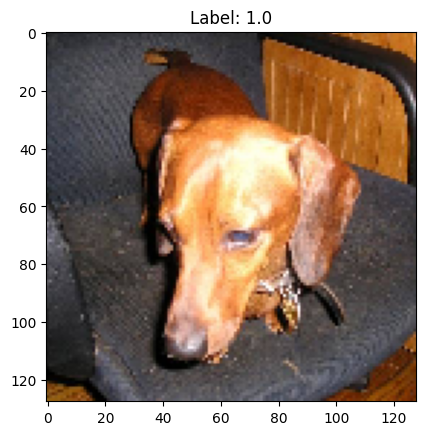

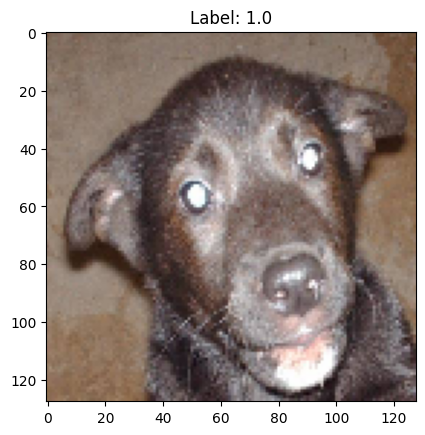

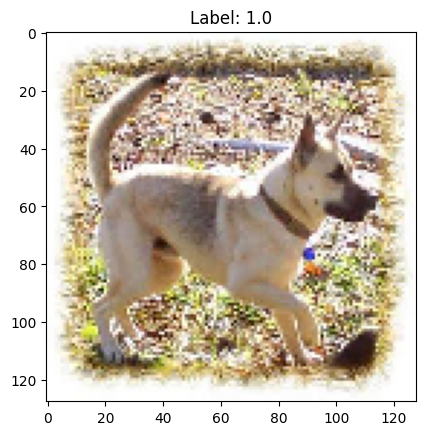

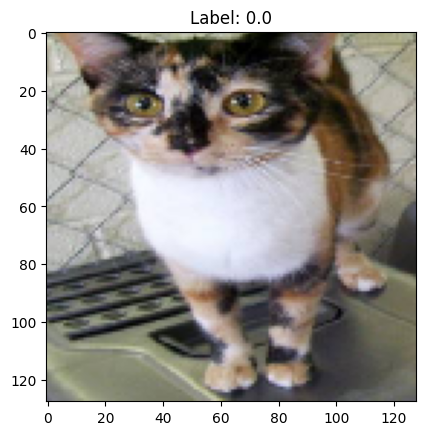

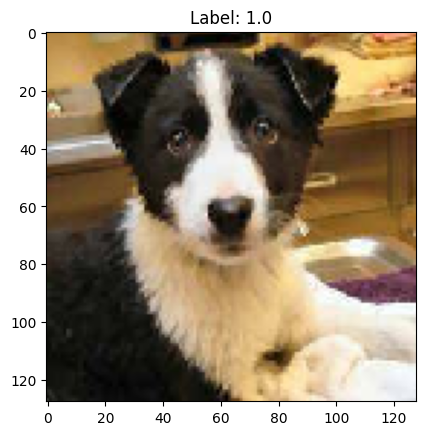

In [ ]:
# Data verification
# Display some images and labels from the training generator

batch_x, batch_y = next(train_generator)
for i in range(5):
  image = batch_x[i]
  label = batch_y[i]
  plt.imshow(image)
  plt.title(f"Label: {label}")
  plt.show()

### 2. Image Preprocessing
Before training the SVM, the images must be preprocessed:
- **Resizing**: Standardize all images to a fixed size (e.g., 128x128 pixels) for uniformity.
- **Color Transformation**:
  - Convert images to grayscale to reduce dimensionality (optional).
  - Alternatively, use RGB channels for richer features.
- **Normalization**: Scale pixel values to the range [0, 1] to improve model performance.

In [ ]:
# Resizing was already handled in the dataset preparation phase

# Color Transformation
# Define a preprocessing function to convert to grayscale
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)  # Expand dimensions if necessary
    return image

# Create ImageDataGenerator with preprocessing_function
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=to_grayscale_then_rgb
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=to_grayscale_then_rgb
)

### 3. Feature Extraction
Since SVMs work with tabular data, we need to convert images into numerical feature vectors:
- **Flattening**: Convert each image into 3 1D vector of pixel values.
- **Feature Engineering**: Use feature extraction techniques such as:
  - **Histogram of Oriented Gradients (HOG)** for capturing edge patterns.
  - **Principal Component Analysis (PCA)** for dimensionality reduction.

In [ ]:
# Feature extraction using Histogram of Oriented Gradient(HOG)
from skimage.feature import hog
def extract_hog_features(image):
    """
    Extracts HOG features using optimized parameters.
    """
    if image.ndim == 3:  # Check if image has 3 dimensions (RGB)
        image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)

    hog_features, _ = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),  # Larger cell size for speed
        cells_per_block=(2, 2),
        visualize=True,
        block_norm='L2-Hys'
    )
    return hog_features

def preprocess_batch(batch_x):
    """
    Converts a batch of images to HOG features.
    """
    features = []
    for img in batch_x:
        # Convert to grayscale
        gray_image = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        # Resize and extract HOG features
        features.append(extract_hog_features(gray_image))
    return features

# Sequentially Process the Dataset
def process_dataset(generator, save_path_features, save_path_labels):
    """
    Processes the entire dataset and caches the features and labels.
    """
    X = []
    y = []

    for batch_x, batch_y in generator:
        batch_features = preprocess_batch(batch_x)
        X.extend(batch_features)
        y.extend(batch_y)

        # Stop when all data is processed
        if len(y) >= generator.samples:
            break

      # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Save features and labels
    np.save(save_path_features, X)
    np.save(save_path_labels, y)
    return X, y

In [ ]:
# Process and Cache Training Data
train_features_path = "X_train_hog.npy"
train_labels_path = "y_train.npy"

if os.path.exists(train_features_path) and os.path.exists(train_labels_path):
    # Load precomputed features
    X_train = np.load(train_features_path)
    y_train = np.load(train_labels_path)
else:
    # Process and save features
    X_train, y_train = process_dataset(train_generator, train_features_path, train_labels_path)

In [ ]:
# Confirm shapes
print(f"Training Features Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")

Training Features Shape: (20000, 1764)
Training Labels Shape: (20000,)


In [ ]:
# Process and Cache Test Data
test_features_path = "X_test_hog.npy"
test_labels_path = "y_test.npy"

if os.path.exists(test_features_path) and os.path.exists(test_labels_path):
    # Load precomputed test features
    X_test = np.load(test_features_path)
    y_test = np.load(test_labels_path)
else:
    # Process and save test features
    X_test, y_test = process_dataset(test_generator, test_features_path, test_labels_path)

In [ ]:
# Confirm shapes
print(f"Test Features Shape: {X_test.shape}")
print(f"Test Labels Shape: {y_test.shape}")


Test Features Shape: (5000, 1764)
Test Labels Shape: (5000,)


In [ ]:
# Applying PCA
from sklearn.decomposition import PCA

# Step 6: Feature Reduction using PCA
def apply_pca(X, n_components=50):
    """
    Applies PCA to reduce dimensionality of feature data.

    Args:
        X (ndarray): Feature data.
        n_components (int): Number of principal components to retain.

    Returns:
        X_reduced (ndarray): Reduced feature data.
        pca (PCA): The trained PCA object for potential inverse transformation.
    """
    print("Applying PCA...")
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    print(f"Original Feature Size: {X.shape[1]}, Reduced Feature Size: {X_reduced.shape[1]}")
    return X_reduced, pca

# Apply PCA to the training dataset
n_components = 100
X_train_pca, pca = apply_pca(X_train, n_components=n_components)

# Apply the same PCA transformation to the test dataset
X_test_pca = pca.transform(X_test)  # Use the trained PCA to ensure consistency

# Confirm new shapes
print(f"Reduced Training Features Shape: {X_train_pca.shape}")
print(f"Reduced Test Features Shape: {X_test_pca.shape}")



Applying PCA...
Original Feature Size: 1764, Reduced Feature Size: 100
Reduced Training Features Shape: (20000, 100)
Reduced Test Features Shape: (5000, 100)


## 4. Training the SVM
- **Kernel Selection**: Use the RBF kernel or linear kernel depending on the data characteristics.
- **Hyperparameter Tuning**:
  - `C`: Regularization parameter to balance margin size and misclassification.
  - `gamma`: Kernel coefficient for RBF kernel.
- **Training**: Use the training set to fit the SVM model on the extracted features.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train the SVM Model
def train_svm(X_train, y_train, kernel="rbf"):
  """
  Trains an SVM model with a specified kernel and returns the trained model.

  Args:
      X_train (ndarray): Training features.
      y_train (ndarray): Training labels.
      kernel (str): Kernel type for SVM ('rbf' or 'linear').

  Returns:
      svm_model: Trained SVM model.
  """

  print("Training SVM...")
  svm = SVC(kernel=kernel, C=1.0, gamma="scale", random_state=42)
  svm.fit(X_train, y_train)
  print("SVM Training completed.")
  return svm

  # Train a default SVM model (with RBF kernel as baseline)
svm_model = train_svm(X_train_pca, y_train)

# Hyperparameter Tuning with GridSearchCV
def tune_svm_hyperparameters(X_train, y_train):
    """
    Tunes SVM hyperparameters using GridSearchCV and returns the best model.

    Args:
        X_train (ndarray): Training features.
        y_train (ndarray): Training labels.

    Returns:
        best_model (SVC): SVM model with the best hyperparameters.
    """
    print("Tuning SVM hyperparameters...")
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': ['linear', 'rbf']
    }
    grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    return best_model

# Tune hyperparameters
best_svm_model = tune_svm_hyperparameters(X_train_pca, y_train)


Training SVM...
SVM Training completed.
Tuning SVM hyperparameters...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


## 5. Model Evaluation
Evaluate the model's performance using the test dataset:
- **Metrics**:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
- **Confusion Matrix**: Visualize true positives, false positives, false negatives, and true negatives.


### Model Evaluation ###

Accuracy: 0.7838
Precision: 0.7812
Recall: 0.7884
F1-Score: 0.7848

Classification Report:
               precision    recall  f1-score   support

         Cat       0.79      0.78      0.78      2500
         Dog       0.78      0.79      0.78      2500

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000



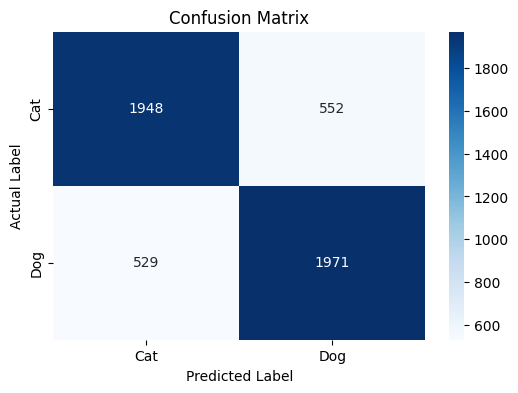

[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  32.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 1.0min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  31.1s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  26.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  45.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  57.8s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=  50.8s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  46.7s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  41.5s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=  50.1s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  49.7s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 2.1min
[CV] END ...................

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Step 5: Model Evaluation
def evaluate_svm_model(model, X_test, y_test):
    """
    Evaluates the SVM model using accuracy, precision, recall, F1 score, and confusion matrix.

    Args:
        model (SVC): Trained SVM model.
        X_test (ndarray): Test features.
        y_test (ndarray): True labels for the test set.

    Returns:
        None: Displays metrics and confusion matrix.
    """
    print("\n### Model Evaluation ###\n")

    # Predictions
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, and F1-Score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Detailed Classification Report
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Evaluate the trained SVM model
evaluate_svm_model(best_svm_model, X_test_pca, y_test)


## Prediction on test dataset

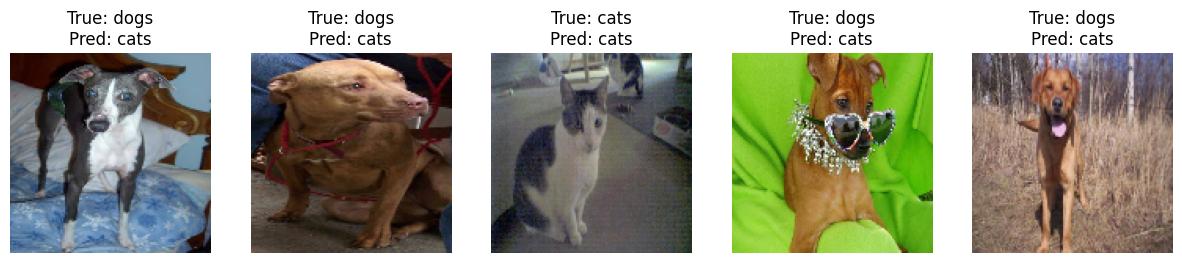

In [ ]:
# Fetch a single batch of test images and labels from the generator
batch_test_x, batch_test_y = next(test_generator)

# Predict the labels for the corresponding batch using the trained PCA and SVM
batch_test_x_flat = [extract_hog_features(image) for image in batch_test_x]
batch_test_x_pca = pca.transform(batch_test_x_flat)
batch_test_y_pred = svm_model.predict(batch_test_x_pca)

# Visualize predictions
def visualize_predictions(images, true_labels, predicted_labels, class_names, num_samples=5):
    """
    Visualize test images along with their true and predicted labels.
    """
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))  # Randomly select samples
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])  # Show the original image
        true_label = class_names[int(true_labels[idx])]
        pred_label = class_names[int(predicted_labels[idx])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.show()

# Map indices back to class names
class_names = {v: k for k, v in test_generator.class_indices.items()}

# Visualize the predictions
visualize_predictions(batch_test_x, batch_test_y, batch_test_y_pred, class_names)


## 6. Prediction on Unseen Images
- Prepare a few unseen images for testing.
- Preprocess these images and pass them through the trained model.
- Observe the classification results to verify the model's effectivence.

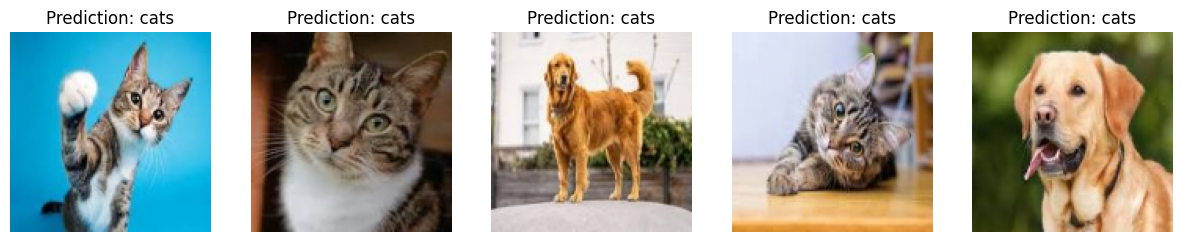

In [ ]:
import os
from skimage.io import imread
from skimage.transform import resize

# Path to the unseen images directory
unseen_images_dir = "/kaggle/input/unseen-dog-cat-images"

# Function to load and preprocess unseen images
def load_and_preprocess_unseen_images(directory, target_size=(128, 128)):
    """
    Load images from a directory and preprocess them for prediction.
    Args:
        directory (str): Path to the directory containing unseen images.
        target_size (tuple): Target size for resizing images (height, width).
    Returns:
        preprocessed_features (list): Extracted HOG features from unseen images.
        original_images (list): Original images for visualization.
    """
    preprocessed_features = []
    original_images = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            # Load and resize the image
            image = imread(file_path)
            image_resized = resize(image, target_size, anti_aliasing=True)
            original_images.append(image_resized)

            # Extract HOG features
            features = extract_hog_features(image_resized)
            preprocessed_features.append(features)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    return preprocessed_features, original_images

# Load and preprocess unseen images
unseen_features, original_unseen_images = load_and_preprocess_unseen_images(unseen_images_dir)

# Apply PCA to reduce dimensions
unseen_features_pca = pca.transform(unseen_features)

# Predict labels using the trained SVM model
unseen_predictions = svm_model.predict(unseen_features_pca)

# Map class indices to names
class_names = {v: k for k, v in test_generator.class_indices.items()}

# Visualize predictions
def visualize_unseen_predictions(images, predictions, class_names, num_samples=5):
    """
    Visualize unseen images with predicted labels.
    """
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        pred_label = class_names[int(predictions[i])]
        plt.title(f"Prediction: {pred_label}")
        plt.axis("off")
    plt.show()

# Visualize predictions for unseen images
visualize_unseen_predictions(original_unseen_images, unseen_predictions, class_names)
